# Alzheimer's Prediccion (Multi-Class) 
* Ver [Alzheimer's Prediccion](https://github.com/jesymca/Alzheimers-Prediccion) para un resumen de este proyecto

### Descripciones de variables
* `Subject ID` Id asignado a los directorios de imágenes.
* `MRI ID` Id de identificacion de Resonancia Magnetica
* `Group` Grupo al que pertenece Demente o no Demente
* `Visit` Numero de Visita
* `MR Delay` Retraso de MR
* `M/F` Masculino o Femenino
* `Hand` Derecho o Izquierdo
* `Age` Edad
* `EDUC` Años de educacion
* `SES` Estatus socioeconómico según lo evaluado por el índice de posición social de Hollingshead y clasificado en categorías de 1 (estatus más alto) a 5 (estatus más bajo)
* `MMSE` Puntuación del Mini-Examen del Estado Mental del MMSE (el rango es de 0 peor a 30 mejor)
* `CDR`	Clasificación clínica de demencia CDR. (0 = sin demencia, 0,5 = EA muy leve, 1 = EA leve, 2 = EA moderada)
* `eTIV` Volumen intracraneal total estimado (cm3)
* `nWBV` Volumen total del cerebro normalizado, expresado como porcentaje de todos los vóxeles en la imagen enmascarada del atlas que están etiquetados como materia gris o blanca por el proceso automatizado de segmentación de tejido
* `ASF` Factor de escala calculado que transforma el cerebro y el cráneo del espacio nativo en el objetivo del atlas (es decir, el determinante de la matriz de transformación)


# Nota: este cuaderno está siendo refactorizado
* Más AED
* División adecuada de prueba
* Use **AUC** como métrica principal para la evaluación, así como **Precisión**
* Falta comparativa

In [112]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [113]:
#Leer Datos
dat = pd.read_csv('oasis_longitudinal_demographics.csv')


In [114]:
#Echar un vistazo a los datos
dat.head(3)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0,"1986,55","0,696106","0,88344"
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0,"2004,47952632607","0,681062","0,875539"
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,"0,5","1678,29","0,736336","1,04571"


### Remover ID's y otras características

In [115]:
X = dat
X=X.drop(['Subject ID','MRI ID','Hand'],axis=1)

print('Dejando Columnas Necesarias')
X.head()

Dejando Columnas Necesarias


,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,87,14,2.0,27.0,0,"1986,55","0,696106","0,88344"
1,Nondemented,2,457,M,88,14,2.0,30.0,0,"2004,47952632607","0,681062","0,875539"
2,Demented,1,0,M,75,12,NaN,23.0,"0,5","1678,29","0,736336","1,04571"
3,Demented,2,560,M,76,12,NaN,28.0,"0,5","1737,62","0,713402","1,01"
4,Demented,3,1895,M,80,12,NaN,22.0,"0,5","1697,91113394342","0,701236","1,033623"


<span style="color:purple;font-size:1.4em;"><b>Explicacion :</b> </span><b> Subject ID, MRI ID y Hand son irrelevante para el analisis de datos</b>

In [116]:
df_dementia1=X
X.shape

(373, 12)

In [117]:
X.dtypes

Group        object
Visit         int64
MR Delay      int64
M/F          object
Age           int64
EDUC          int64
SES         float64
MMSE        float64
CDR          object
eTIV         object
nWBV         object
ASF          object
dtype: object

In [118]:
X.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000


In [119]:
X.describe(include='object')

,Group,M/F,CDR,eTIV,nWBV,ASF
count,373,373,373,373,373,373
unique,3,2,4,371,373,371
top,Nondemented,F,0,"1402,1","0,696106","1,25169"
freq,190,213,206,2,1,2


In [120]:
X.isnull().sum()

Group        0
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [121]:
X.SES.describe()

count    354.000000
mean       2.460452
std        1.134005
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: SES, dtype: float64

In [122]:
X.SES.mode()

0    2.0
Name: SES, dtype: float64

In [123]:
X.SES.unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

<span style="color:purple;font-size:1.4em;"><b>Explicacion :</b> </span> 
<b>SES solo tiene valores enteros por ello se debe reemplazar por la media o el modo</b>

In [124]:
X.SES.mean()

2.4604519774011298

In [125]:
X.SES.median()

2.0

In [126]:
X.MMSE.mode()
X.MMSE.unique()
X.MMSE.describe()

count    371.000000
mean      27.342318
std        3.683244
min        4.000000
25%       27.000000
50%       29.000000
75%       30.000000
max       30.000000
Name: MMSE, dtype: float64

<AxesSubplot: >

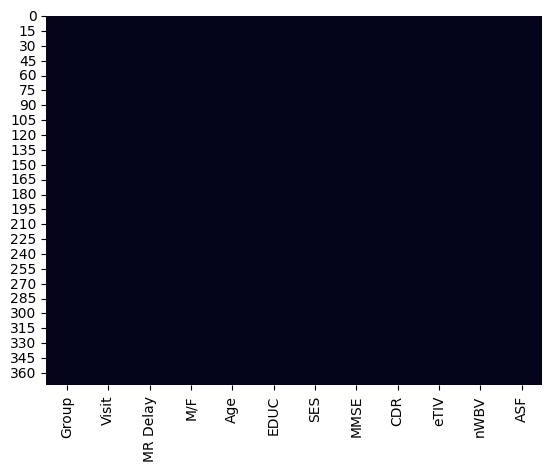

In [127]:
X["SES"].fillna(X["SES"].median(), inplace=True)
X["MMSE"].fillna(X["MMSE"].median(), inplace=True)
sns.heatmap(data=X.isnull(),cbar=False)

<span style="color:purple;font-size:1.4em;"><b>Explicacion :</b> </span> 
<b>Ahora faltan valores, así que podemos avanzar.</b>

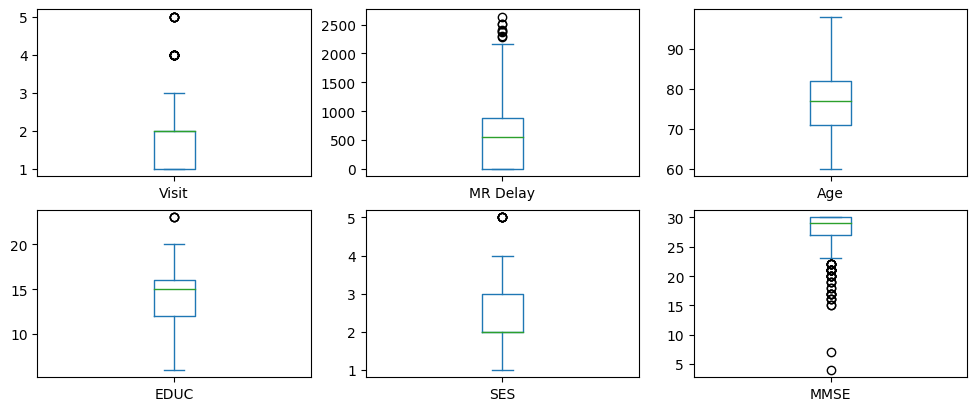

In [128]:
X.plot(kind='box',figsize=(12,10),subplots=True,layout=(4,3))
plt.show()

In [129]:
X.drop(["Visit","MR Delay"],axis=1,inplace=True)
X["Group"].replace({"Nondemented":0,"Demented":1},inplace=True)
X["M/F"].replace({"M":0,"F":1},inplace=True)
X.head(5)

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,87,14,2.0,27.0,0,"1986,55","0,696106","0,88344"
1,0,0,88,14,2.0,30.0,0,"2004,47952632607","0,681062","0,875539"
2,1,0,75,12,2.0,23.0,"0,5","1678,29","0,736336","1,04571"
3,1,0,76,12,2.0,28.0,"0,5","1737,62","0,713402","1,01"
4,1,0,80,12,2.0,22.0,"0,5","1697,91113394342","0,701236","1,033623"
